In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.dataLoader import loadSession
from src.features import *

Preprocessing

In [2]:
# loading all the sessions in Hungarian GP

fp1 = loadSession(2024, 'Hungary', 'FP1')
fp2 = loadSession(2024, 'Hungary', 'FP2')
fp3 = loadSession(2024, 'Hungary', 'FP3')
quali = loadSession(2024, 'Hungary', 'Q')
race = loadSession(2024, 'Hungary', 'R')

core           INFO 	Loading data for Hungarian Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '31', '44', '50', '55', '63', '77', '81']
core           INFO 	Loading data for Hungarian Grand Prix - Practice 2 [v3.6.0]
req            INFO 	Using

In [3]:
df = getBestLaps(fp1)
df = df.merge(getAvg_top3Laps(fp2), on="Driver", how="outer")
df = df.merge(getAvg_top3Laps(fp3), on="Driver", how="outer")
df = df.merge(getQualiResults(quali), on="Driver", how="outer")
df = df.merge(getRacePositions(race), on="Driver", how="outer")


In [4]:
df.sort_values('Race_result', inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head(10)

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,0 days 00:01:19.249000,0 days 00:01:19.438333333,0 days 00:01:16.902000,2.0,1
1,STR,0 days 00:01:19.265000,0 days 00:01:19.606666666,0 days 00:01:17.939000,8.0,10
2,ALO,0 days 00:01:19.686000,0 days 00:01:19.247000,0 days 00:01:17.614333333,7.0,11
3,RIC,0 days 00:01:19.578000,0 days 00:01:18.689500,0 days 00:01:17.334000,9.0,12
4,HUL,NaT,0 days 00:01:19.366666666,0 days 00:01:17.283000,11.0,13
5,ALB,0 days 00:01:19.794000,0 days 00:01:19.065666666,0 days 00:01:17.279000,13.0,14
6,MAG,0 days 00:01:20.295000,0 days 00:01:19.502000,0 days 00:01:17.854666666,15.0,15
7,BOT,0 days 00:01:19.804000,0 days 00:01:18.946000,0 days 00:01:17.577666666,12.0,16
8,SAR,0 days 00:01:19.885000,0 days 00:01:19.074000,0 days 00:01:17.637333333,14.0,17
9,OCO,0 days 00:01:20.023000,0 days 00:01:19.194666666,0 days 00:01:17.973000,19.0,18


In [6]:
from src.preProcessing import processFeatures

df_clean = processFeatures(df)
df_clean.head()

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,0 days 00:01:19.249000,79.438333,76.902000,2.0,1
1,STR,0 days 00:01:19.265000,79.606667,77.939000,8.0,10
2,ALO,0 days 00:01:19.686000,79.247000,77.614333,7.0,11
3,RIC,0 days 00:01:19.578000,78.689500,77.334000,9.0,12
4,HUL,NaT,79.366667,77.283000,11.0,13


In [7]:
for column in df_clean.columns:
  print (column)

Driver
Practice 1_BestLap
Practice 2_Top3Average
Practice 3_Top3Average
Quali_Position
Race_result


In [15]:
df["Practice 1_BestLap"] = pd.to_timedelta(df["Practice 1_BestLap"], errors="coerce")
df["Practice 1_BestLap"] = df["Practice 1_BestLap"].dt.total_seconds()

df_clean = df[df["Race_result"].apply(lambda x: str(x).isdigit())].copy()
df_clean["Race_result"] = df_clean["Race_result"].astype(int)


In [16]:
df.head(10)

,Driver,Practice 1_BestLap,Practice 2_Top3Average,Practice 3_Top3Average,Quali_Position,Race_result
0,PIA,7.900000e-08,79.438333,76.902000,2.0,1
1,STR,7.900000e-08,79.606667,77.939000,8.0,10
2,ALO,7.900000e-08,79.247000,77.614333,7.0,11
3,RIC,7.900000e-08,78.689500,77.334000,9.0,12
4,HUL,NaN,79.366667,77.283000,11.0,13
5,ALB,7.900000e-08,79.065667,77.279000,13.0,14
6,MAG,8.000000e-08,79.502000,77.854667,15.0,15
7,BOT,7.900000e-08,78.946000,77.577667,12.0,16
8,SAR,7.900000e-08,79.074000,77.637333,14.0,17
9,OCO,8.000000e-08,79.194667,77.973000,19.0,18


Preparing the features and target

In [24]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=["Driver", "Race_result"])
y = df_clean["Race_result"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Using Xg boost for training the model

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")


MAE: 2.25


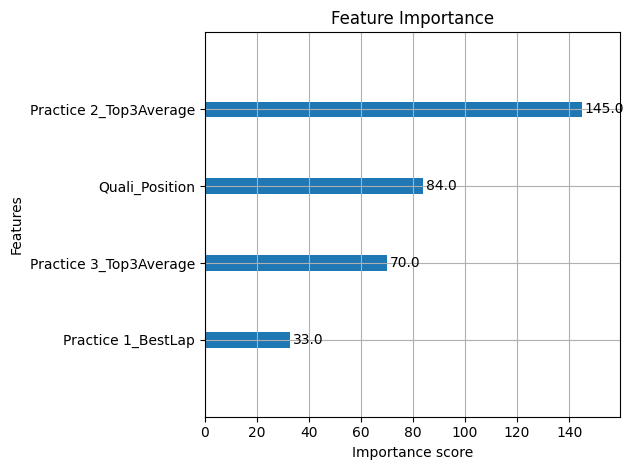

In [26]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()